# Homework 1 - data validation & cleaning (deadline 31. 10. 2020)

In short, the main task is to clean The Metropolitan Museum of Art Open Access dataset.
  
> The instructions are not given in details: It is up to you to come up with ideas on how to fulfill the particular tasks as best you can!

## What are you supposed to do:

  1. Download the dataset MetObjects.csv from the repository https://github.com/metmuseum/openaccess/.
  2. Check consistency (i.e. that same things are represented in the same way) of at least three features where you expect problems (include "Object Name" feature). You can propose how to clean selected features, however do not apply cleaning (in your interest) :)
  3. Select some features where you expect integrity problems (describe your choice) and check integrity of those features. By integrity we mean correct logical relations between features (e.g. female names for females only).
  4. Convert at least five features to a proper data type. Choose at least one numeric, one categorical and one datetime.
  5. Find some outliers (describe your method).
  6. Detect missing data in at least three features, convert them to a proper representation (if they are already not), and impute missing values in at least one feature.

**If you do all this properly, you will obtain 16 points.** However, all your steps and following code **have to be commented!**

To earn **two points** for extra activity you can do some of these:
  * Focus more precisely on cleaning of the "Medium" feature. Such if you like to use it in KNN based algorithms later.
  * Focus on the extraction of physical dimensions of each item (width, depth and height in centimeters) from the "Dimensions" feature.

## Comments

  * Please follow the instructions from https://courses.fit.cvut.cz/MI-PDD/homeworks/index.html.
  * If the reviewing teacher is not satisfied, she can (!) give you another chance to rework your homework and to obtain more points. However, this is not a given, so do your best! :)

In [1]:
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from scipy.stats import chi2_contingency
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
%matplotlib inline

In [2]:
df = pd.read_csv('MetObjects.csv', low_memory=False)

Display basic info about the dataframe

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 474526 entries, 0 to 474525
Data columns (total 54 columns):
Object Number              474526 non-null object
Is Highlight               474526 non-null bool
Is Timeline Work           474526 non-null bool
Is Public Domain           474526 non-null bool
Object ID                  474526 non-null int64
Gallery Number             54386 non-null object
Department                 474526 non-null object
AccessionYear              470560 non-null object
Object Name                473172 non-null object
Title                      444655 non-null object
Culture                    206456 non-null object
Period                     90362 non-null object
Dynasty                    23144 non-null object
Reign                      11180 non-null object
Portfolio                  23344 non-null object
Constiuent ID              272672 non-null object
Artist Role                270578 non-null object
Artist Prefix              89303 non-null object
Ar

## 2) Consistency check
### Check where incosistency is caused by only letter case (Object Name included)
Cleaning could be applied simply by str.lower() method

In [4]:
def check_cons_by_str(col_name, df):
    #Checks consistency of column by letter case.
    on_unique_len = len(df[str(col_name)].astype(str).unique())
    on_unique_lowered_len = len(df[str(col_name)].astype(str).str.lower().unique())
    res = on_unique_len - on_unique_lowered_len
    not_null_len = max(len(df[col_name].dropna()), 1)                
    return res, 'There are {0} ambigous values in {1}, which is {2} % of not null values'.format(res, col, round(res * 100 / not_null_len, 2))

Print significantly incosistent columns

In [5]:
for col in df.columns:
    cnt, statement = check_cons_by_str(col, df)
    if cnt > 100:
        print(statement)

There are 823 ambigous values in Object Name, which is 0.17 % of not null values
There are 2052 ambigous values in Title, which is 0.46 % of not null values
There are 167 ambigous values in Artist Prefix, which is 0.19 % of not null values
There are 154 ambigous values in Object Date, which is 0.03 % of not null values
There are 1296 ambigous values in Medium, which is 0.28 % of not null values
There are 1366 ambigous values in Dimensions, which is 0.34 % of not null values
There are 210 ambigous values in Credit Line, which is 0.04 % of not null values


### Incosistency caused by multiple values in one feature
This data is mess, splitting into multiple tables will be probably the best solution. Or we could use "get_dummies" method to create new columns in df with ones at appropriate rows. <br>
E.g. American|French|American is not the same as French|American|Amercian. This could be solved by alphabetical sorting, but it would break the integrity constraint, as it would break the order of values separeted by '|', therefore this solution is unacceptable.

In [6]:
for col in df.columns:
    # regex check wheter the values in col are separeted by '|'
    mask = df[col].astype(str).str.contains('..*\|..*', regex=True)
    s = mask.sum()
    if s > 30000:
        not_null_len = max(len(df[col].dropna()), 1)     
        print('There are {0} multiple values in one row in column {1}, which is {2}% of not null values'.format(s, col, round(s * 100 / not_null_len, 2)))
        print()

There are 92507 multiple values in one row in column Artist Role, which is 34.19% of not null values

There are 92565 multiple values in one row in column Artist Display Name, which is 33.95% of not null values

There are 72747 multiple values in one row in column Artist Display Bio, which is 31.14% of not null values

There are 92544 multiple values in one row in column Artist Alpha Sort, which is 33.94% of not null values

There are 55824 multiple values in one row in column Artist Nationality, which is 30.6% of not null values

There are 69474 multiple values in one row in column Artist Begin Date, which is 29.41% of not null values

There are 69223 multiple values in one row in column Artist End Date, which is 29.3% of not null values

There are 52960 multiple values in one row in column Artist ULAN URL, which is 25.97% of not null values

There are 63599 multiple values in one row in column Classification, which is 15.2% of not null values

There are 130347 multiple values in one 

Object Date is also a mess. Will try to apply some simple cleainig in Integrity detection part. More complex cleaning is possible by detecting numbers in the feaure, decide what they are representing (century, millenia, decade, year) and parse then approprietly. Would be also worth considering to introduce new columns as "certainty" for values like "probably 19th century".

In [7]:
print(df['Object Date'].sample(10))

380843                   before 1703
392827                          1776
228453    early to mid-16th century 
325219                      ca. 1927
35955              late 17th century
223048                       1866–69
347054            ca. 2051–2030 B.C.
56796              18th–19th century
329988                          1942
432118     probably 8th–12th century
Name: Object Date, dtype: object


# 3) Integrity detection
We will check integrity of Dates columns, wheter they satisfy following constraints: <br/>
a) End date >= Begin date <br/>
b) End date = to(Object Date) & Begin date = from(Object Date)

In [8]:
END_LESSER_BEGIN_FLAG = 1
ACTUAL_NOT_CORRESPONDING_FLAG = 2

def is_viloation(row):
    # Checks violation of following constraints:
    # End date < Begin date
    # Object date does not match with Begin date - end date
    ret = 0
    begin = row['Object Begin Date']
    end = row['Object End Date']
    actual = row['Object Date']
    if end < begin:
        ret = END_LESSER_BEGIN_FLAG
    if actual is None:
        return ret
    splitted = str(actual).split('-')
    #Checks if Object Date corresponds with Begin-End date
    if len(splitted) > 1:
        first, second = int(splitted[0]), int(splitted[1])
        if first!=begin or second!=end:
            ret |= ACTUAL_NOT_CORRESPONDING_FLAG
    else:
        if not begin==end and str(actual) != 'nan':
            ret |= ACTUAL_NOT_CORRESPONDING_FLAG
    return ret

    
def is_int(s):
    # Helper for checking if s is an integer
    try: 
        int(s)
        return True
    except ValueError:
        return False

def parse_object_date(val):
    # Rewrites Object Date in format DXX-XX to DXX-DXX.
    if is_int(val):        
        return val
    splitted = str(val).strip().split('-')
    if len(splitted) > 1:
        if is_int(splitted[0]):
            first = splitted[0]
            diff = len(splitted[0]) - len(splitted[1])
            if diff >= 0:
                second = splitted[0][:diff] + splitted[1]
                return first + "-" + second
            if len(splitted[0]) == len(splitted[1]):
                return val
    return None

In [9]:
# Those tasks can take up to 20 seconds
# Parse dates
df['Object Date'] = df['Object Date'].apply(lambda x: parse_object_date(x)).dropna()
# Create new column to check, if there is a constraint violation
df['Date_Integrity_Violation'] = df.apply(lambda row: is_viloation(row), axis=1)

a) Constraint End Date < Begin date violation

In [10]:
filt = df[df['Date_Integrity_Violation'] == 1]
print('There are overall {0} violations, sample:'.format(len(filt)))
filt[['Object Begin Date', 'Object End Date']].sample(10)

There are overall 188 violations, sample:


,Object Begin Date,Object End Date
347514,-664,-688
347521,-664,-688
249469,1785,1780
355738,-664,-688
355726,-664,-688
136473,1785,1773
355724,-664,-688
347971,-664,-688
355742,-664,-688
355716,-664,-688


b) Constraint Object Date violation

In [11]:
filt = df[df['Date_Integrity_Violation'] == 2]
print('There are overall {0} violations, displaying sample:'.format(len(filt)))
filt[['Object Begin Date', 'Object Date', 'Object End Date']].dropna().sample(10)

There are overall 1221 violations, displaying sample:


,Object Begin Date,Object Date,Object End Date
179395,1854,1854,1859
422980,1890,1903,1903
179386,1854,1854,1859
159445,1947,1949,1949
262766,1723,1724,1724
268247,1611,1611,1612
337376,1850,1875,1900
179400,1854,1854,1859
221719,1800,1873,1958
424393,1584,1589,1594


Display rows satisfying our consraints

In [12]:
filt = df[df['Date_Integrity_Violation'] == 0]
filt = filt[filt['Object Date'].str.len() > 4]
print('{0} rows are OK, sample:'.format(len(filt)))
filt[['Object Begin Date', 'Object Date', 'Object End Date']].dropna().sample(10)

497 rows are OK, sample:


,Object Begin Date,Object Date,Object End Date
427597,1545,1545-1547,1547
391171,1933,1933-1939,1939
426878,1565,1565-1570,1570
391909,1933,1933-1939,1939
462331,1885,1885-1900,1900
232511,1525,1525,1525
426685,1548,1548-1549,1549
423416,1889,1889-1890,1890
225204,1509,1509-1510,1510
427620,1545,1545-1547,1547


## 4) Conversion
Create two new columns for later use <br>
Object {Begin,End} Date -> date <br>       
Culture, Period -> categorical <br>    
Gallery Number -> int <br>   
Object name -> str <br>   

In [13]:
df['Object Begin Year'] = df['Object Begin Date'].apply(pd.to_numeric, errors='coerce')
df['Object End Year'] = df['Object End Date'].apply(pd.to_numeric, errors='coerce')

In [14]:
df['Object Begin Date'] = pd.to_datetime(df['Object Begin Date'], format='%Y', errors='coerce')
df['Object End Date'] = pd.to_datetime(df['Object End Date'], format='%Y', errors='coerce')
df['Culture'] = df['Culture'].astype('category').cat.codes
df['Period'] = df['Period'].astype('category').cat.codes                               
df['Gallery Number'] = pd.to_numeric(df['Gallery Number'], errors='coerce')
df['Object Name'] = df['Object Name'].apply(str)

for c in ['Object Begin Date', 'Object End Date', 'Culture', 'Period', 'City', 'State', 'Gallery Number', 'Object Name']:
    print(c)
    print(df[c].dropna().sample(3))
    print()

Object Begin Date
300245   1700-01-01
174747   1965-01-01
9356     1875-01-01
Name: Object Begin Date, dtype: datetime64[ns]

Object End Date
93171    1887-01-01
56546    1899-01-01
175869   1912-01-01
Name: Object End Date, dtype: datetime64[ns]

Culture
343295   -1
242267   -1
249476   -1
Name: Culture, dtype: int16

Period
400228      -1
391180      -1
358725    1084
Name: Period, dtype: int16

City
289140    The Hague
432129     Nishapur
300628        Herat
Name: City, dtype: object

State
3204    Lancaster County
5582       Staffordshire
5782       Staffordshire
Name: State, dtype: object

Gallery Number
357037    122.0
354284    126.0
346927    122.0
Name: Gallery Number, dtype: float64

Object Name
356499    Relief fragment, tomb of Meketre
349552                     Vessel fragment
437496                Lekanis lid fragment
Name: Object Name, dtype: object



## 5) Outliers
Find outliers in Date feature, first, plot as boxplot.

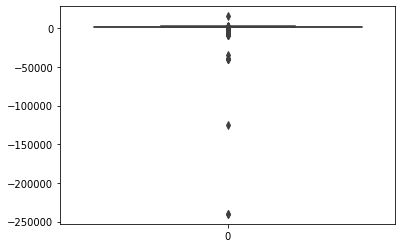

In [15]:
sns.boxplot(data=df['Object End Year'])

We'll use IQR method which basically checks, which values lies outside this range: <Q1-1.5*IQR IQR, Q3+1.5*IQR>, those values are considered as outliers.

In [16]:
# IQR method
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR =  Q3 - Q1

date_outlier_mask = (df['Object End Year'] > Q3['Object End Year'] + 1.5*IQR['Object End Year']) | (df['Object End Year'] < Q1['Object End Year'] - 1.5*IQR['Object End Year'])

print('Outliers lying above "normal" range: ')
print(df[date_outlier_mask].sort_values(['Object End Date'], ascending = False).head(5)['Object End Year'])
print('Outliers lying below "normal" range: ')
df[date_outlier_mask].sort_values(['Object End Year']).head(5)['Object End Year']

Outliers lying above "normal" range: 
2396     0
11886    0
13349    0
13486    0
13523    0
Name: Object End Year, dtype: int64
Outliers lying below "normal" range: 


363915   -240000
363923   -240000
470122   -125000
363913    -40000
363912    -40000
Name: Object End Year, dtype: int64

## 6) Missing features
We can see how many values are missing in above "df.info()" result. We'll fill Object Name with empty string, Gallery Number with zeroes and City with unknown. There is also indicator for unknown Dimensions "Dimensions unavailable"

In [17]:
df['Object Name'] = df['Object Name'].fillna(' ')
df['Gallery Number'] = df['Gallery Number'].fillna(0)
df['City'] = df['City'].fillna('unknown')
df['Dimensions'] = df['Dimensions'].fillna('Dimensions unavailable.')

In [18]:
# Create mask for missing dates, we will use it later
missing_date_mask = df['Object Date'].isnull()

Fill missing object dates by Begin to End Year range.

In [19]:
df['Object Date'] = df['Object Date'].fillna(df['Object Begin Year'].astype(str) + '-' + df['Object End Year'].astype(str))
print('Parsed values are: ')
df[missing_date_mask][['Object Date', 'Object Begin Year', 'Object End Year']].sample(5)

Parsed values are: 


,Object Date,Object Begin Year,Object End Year
145208,-699--400,-699,-400
253520,1850-1900,1850,1900
365456,-664--610,-664,-610
256547,1780-1800,1780,1800
309526,400-1399,400,1399


Try to create dictionary of city:state and use it to fill some null values whene city is known and state is not.

In [20]:
g = df.groupby('City')
df2 = g.apply(lambda x: x['Country'].dropna().unique())
df2.dropna()
m = dict()
for r in zip(g, df2):
    try:
        v = r[0][0]
        if v =='unknown':
            continue
        m[r[0][0]] = r[1][0]
    except:
        continue

In [21]:
initinaly_null = df['State'].isnull().sum()

In [22]:
df['State'] = df['State'].fillna(df['City'].apply(lambda x: m.get(x)))

In [23]:
post_null = df['State'].isnull().sum()
print('By the dictionary method, we filled {0} values.'.format(initinaly_null - post_null))

By the dictionary method, we filled 29259 values.
